In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt

from sklearn.metrics import fbeta_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

import itertools
import warnings

warnings.filterwarnings(action='once')

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
dataset = pd.read_csv("datasets/cleaned_dataset.csv")

col_variables = [i for i in dataset.columns if i != 'RIESGO_VIDA_enc']

etiquetas = dataset['RIESGO_VIDA_enc']
caracteristicas = dataset[col_variables]

dataset.head()

,TRIM_enc,PQR_CANAL_enc,PET_TIPOPER_enc,PET_DPTO_enc,PET_MPIO_enc,PQR_TIPOPETICION_enc,AFEC_TIPOPER_enc,AFEC_PARENTESCO_enc,AFEC_GENERO_enc,AFEC_EDADR_enc,...,ENT_MPIO_DANE_enc,PQR_CLASE_SNS_enc,MACROMOTIVO_enc,MOTIVO_GENERAL_enc,MOTIVO_ESPECIFICO_enc,PATOLOGIA_1_enc,PATOLOGIA_TIPO_enc,CIE_10_enc,PQR_TIPOATENCION_enc,RIESGO_VIDA_enc
0,0,6,1,1,109,3,1,10,0,4,...,514,0,6,33,101,16,392,6513,2,0
1,0,8,1,1,639,3,1,10,1,5,...,514,0,6,33,101,16,392,6513,2,0
2,0,10,1,1,639,3,1,11,1,8,...,514,0,6,33,101,16,392,6513,2,0
3,1,8,1,1,639,3,1,10,1,8,...,514,0,6,33,101,16,392,6513,2,0
4,1,10,1,1,639,3,1,10,1,3,...,514,0,6,33,101,16,392,6513,2,0


In [3]:
def train_predict(learner, beta_value, X_train, y_train, X_test, y_test, dfResults):
    
    start = time()
    learner = learner.fit(X_train, y_train)
    end = time()

    train_time = end - start

    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time

    pred_time = end - start

    f_train = fbeta_score(y_train, predictions_train, beta_value)

    f_test =  fbeta_score(y_test, predictions_test, beta_value)

    print("Trained. ", learner.__class__.__name__)

    dfResults = dfResults.append({'learner': learner.__class__.__name__, 'train_time': train_time, 'pred_time': pred_time, 'Test': f_test, 'Train':f_train}, ignore_index=True)
    return learner, dfResults


def tune_classifier(clf, parameters, X_train, X_test, y_train, y_test):
    
    c = y_train.shape
    labels = y_train.values.reshape(c,)
    
    scorer = make_scorer(fbeta_score, beta=2)
    
    start = time()
    
    grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, iid=False)
    grid_fit = grid_obj.fit(X_train, labels)
    best_clf = grid_fit.best_estimator_
    
    end = time()
    train_time = end - start
    print(f"Tiempo de entrenamiento: {round(train_time/60, 2)} minutos")
    
    predictions = (clf.fit(X_train, labels)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    default_score = fbeta_score(y_test, predictions, beta = 2)
    tuned_score = fbeta_score(y_test, best_predictions, beta = 2)
    
    cnf_matrix = confusion_matrix(y_test, best_predictions)
    
    print(f"F-score sobre datos de validación: {fbeta_score(y_test, predictions, beta = 2)}")
    print(f"Final F-score sobre datos de validación: {fbeta_score(y_test, best_predictions, beta = 2)}")
    
    return best_clf, default_score, tuned_score, cnf_matrix


def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = ""
    else:
        title = ""

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Vida en riesgo               Vida no en Riesgo')
    plt.xlabel('Vida no en riesgo               Vida en Riesgo')
    plt.tight_layout()

#### Se verifican que todos los datos estén limpios

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102799 entries, 0 to 1102798
Data columns (total 33 columns):
TRIM_enc                  1102799 non-null int64
PQR_CANAL_enc             1102799 non-null int64
PET_TIPOPER_enc           1102799 non-null int64
PET_DPTO_enc              1102799 non-null int64
PET_MPIO_enc              1102799 non-null int64
PQR_TIPOPETICION_enc      1102799 non-null int64
AFEC_TIPOPER_enc          1102799 non-null int64
AFEC_PARENTESCO_enc       1102799 non-null int64
AFEC_GENERO_enc           1102799 non-null int64
AFEC_EDADR_enc            1102799 non-null int64
AFEC_EDUC_enc             1102799 non-null int64
AFEC_REGAFILIACION_enc    1102799 non-null int64
AFEC_GETNICO_enc          1102799 non-null int64
AFEC_POBESPECIAL_enc      1102799 non-null int64
AFEC_MPIO_enc             1102799 non-null int64
AFEC_DPTO_enc             1102799 non-null int64
ENT_NOMBRE_enc            1102799 non-null int64
ENT_TIPOVIG_SNS_enc       1102799 non-null int64
ENT_C

In [5]:
# Import train_test_split
from sklearn.model_selection import train_test_split

X_all_train, X_test, y_all_train, y_test = train_test_split(caracteristicas, etiquetas, test_size=0.2, train_size=0.8)  # 20% de test 
X_train, X_validation, y_train, y_validation = train_test_split(X_all_train, y_all_train, test_size = 0.25,train_size = 0.75)  # 20 de validación, 60 de train

## Modelos sin ajuste de hiperparámetros

In [6]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Initialize the three models
clf_A = GaussianNB()
clf_B = RandomForestClassifier()
clf_C = AdaBoostClassifier()

# Collect results on the learners
dfResults = pd.DataFrame(columns=['learner', 'train_time', 'pred_time', 'Test', 'Train'])

for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__  
    clf, dfResults = train_predict(clf, 1, X_train, y_train, X_test, y_test, dfResults)

Trained.  GaussianNB


/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Trained.  RandomForestClassifier
Trained.  AdaBoostClassifier


In [7]:
dfResults

,learner,train_time,pred_time,Test,Train
0,GaussianNB,0.542429,0.553429,0.470103,0.470136
1,RandomForestClassifier,18.264339,3.073812,0.718481,0.972989
2,AdaBoostClassifier,52.383850,6.612434,0.658522,0.659598


# Tuning the model
## Tuning RandomForestClassifier

In [8]:
from sklearn.metrics import make_scorer

rf_classifier = RandomForestClassifier()

rfParameters = {    
  'criterion':['gini', 'entropy'],
  'max_depth':[5, 10, 15, 30],
  'max_features':['auto', 'sqrt', 'log2', None],
  'class_weight': ['balanced', 'balanced_subsample'], 
}

# run block of code and catch warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    rf_classifier, default_rf_score, tuned_rf_score, cnf_rf_matrix = tune_classifier(rf_classifier, rfParameters, X_train, X_validation, y_train, y_validation)
    
joblib.dump(rf_classifier, 'randomForesteTuned.joblib')

Tiempo de entrenamiento: 40.4 minutos
F-score sobre datos de validación: 0.681985903814262
Final F-score sobre datos de validación: 0.7847487934780518


['randomForesteTuned.joblib']

F-score on testing data: 0.779692903156166


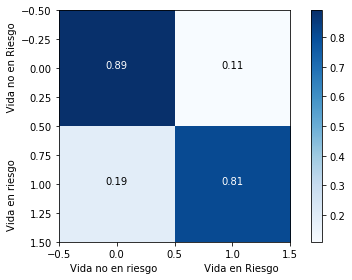

In [9]:
rf_predictions = rf_classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cnf_matrix, normalize = True)
print(f"F-score on testing data: {fbeta_score(y_test, rf_predictions, beta = 2)}")

## Tuning Adaboost

In [19]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier = AdaBoostClassifier()

adaParameters = {
    'algorithm' :['SAMME', 'SAMME.R'],
    'n_estimators': [50, 100],
    'learning_rate' : [0.01, 0.05, 0.1, 0.3, 1]
}
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ada_classifier, default_ada_score, tuned_ada_score, cnf_ada_matrix = tune_classifier(ada_classifier, adaParameters, X_train, X_validation, y_train, y_validation)
    
joblib.dump(rf_classifier, 'adaBoostTuned.joblib') 

Tiempo de entrenamiento: 39.86 minutos
F-score sobre datos de validación: 0.6195465747493922
Final F-score sobre datos de validación: 0.6459701344322937


['adaBoostTuned.joblib']

F-score on testing data: 0.6406907349649276


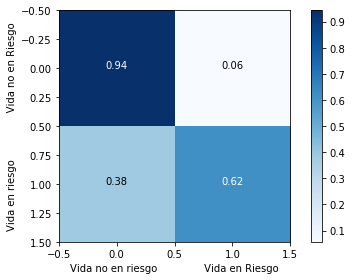

In [20]:
ada_predictions = ada_classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test, ada_predictions)
plot_confusion_matrix(cnf_matrix, normalize = True)
print(f"F-score on testing data: {fbeta_score(y_test, ada_predictions, beta = 2)}")

## Tuning a Gaussian Naive Bayes

In [21]:
gauss_classifier = GaussianNB()

gaussParameters = {
  'priors':[None],
  'var_smoothing' :[1e-09]
}
%time
gauss_classifier, default_gauss_score, tuned_gauss_score, cnf_gauss_matrix = tune_classifier(gauss_classifier, gaussParameters,  X_train, X_test, y_train, y_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Tiempo de entrenamiento: 0.04 minutos
F-score sobre datos de validación: 0.6639982152376979
Final F-score sobre datos de validación: 0.6639982152376979


F-score on testing data: 0.6639982152376979


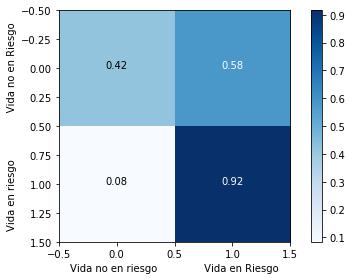

In [22]:
gauss_predictions = gauss_classifier.predict(X_test)
cnf_matrix = confusion_matrix(y_test, gauss_predictions)
plot_confusion_matrix(cnf_matrix, normalize = True)
print(f"F-score on testing data: {fbeta_score(y_test, gauss_predictions, beta = 2)}")

# Stacking
## Stacking with to best classifiers: Random Forest and Adaboost

In [23]:
def get_stack_two(clf_1, clf_2, X_train, X_test, y_train, y_test):
    sclf = StackingClassifier(classifiers=[clf_1, clf_2],
                          use_features_in_secondary = True,
                          meta_classifier=RandomForestClassifier())
    sclf = sclf.fit(X_train, y_train)
    y_predictions = sclf.predict(X_test)
    return sclf, fbeta_score(y_test, y_predictions, beta = 2)

def get_stack_all(clf_1, clf_2, clf_3, X_train, X_test, y_train, y_test):
    sclf = StackingClassifier(classifiers=[clf_1, clf_2, clf_3],
                          use_features_in_secondary = True,
                          meta_classifier= RandomForestClassifier())
    sclf = sclf.fit(X_train, y_train)
    y_predictions = sclf.predict(X_test)
    return sclf, fbeta_score(y_test, y_predictions, beta = 2)


def model_validation(model_path, X_validation, y_validation):
    clf = joblib.load(model_path)

    y_predictions = clf.predict(X_validation)

    print(f"F-score on validation data: {fbeta_score(y_validation, y_predictions, beta = 2)}")

    cnf_matrix = confusion_matrix(y_validation, y_predictions)
    plot_confusion_matrix(cnf_matrix, normalize=True)
    return clf

In [24]:
sclf_two, sclf_score = get_stack_two(rf_classifier, ada_classifier, X_train, X_test, y_train, y_test)

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F-score on validation data: 0.6954432504484342


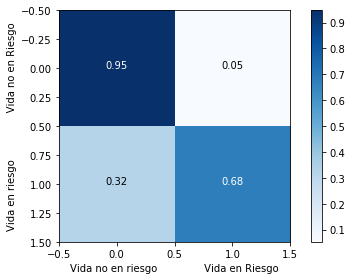

In [25]:
joblib.dump(sclf_two, 'sclf_two.joblib') 

model_validation('sclf_two.joblib', X_test, y_test);

## Stacking with all classifiers

In [26]:
from mlxtend.classifier import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.metrics import fbeta_score, make_scorer

#meta with Gaussian
sclf2 = StackingClassifier(classifiers=[rf_classifier, ada_classifier, gauss_classifier], 
                          use_features_in_secondary = True,
                          meta_classifier=RandomForestClassifier(random_state = 17))
sclf2 = sclf2.fit(X_train, y_train)

/home/juanjosegdoj/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


F-score on testing data: 0.6639982152376979


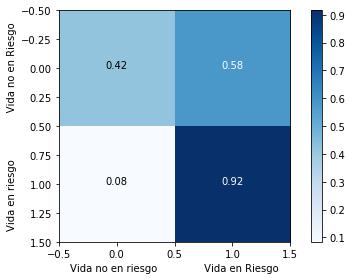

In [27]:
sclf2_predictions = sclf2.predict(X_test)
cnf_matrix = confusion_matrix(y_test, gauss_predictions)
plot_confusion_matrix(cnf_matrix, normalize = True)
print(f"F-score on testing data: {fbeta_score(y_test, gauss_predictions, beta = 2)}")